# EE-411: Final project
## Reproducibility challenge: Reconciling modern machine learning practice and the bias-variance trade-off
### Defne Culha, Hector M. Ramírez C., Riselda Kodra and Valgerdur Jónsdóttir 

In this project, we will attempt to reproduce some of the results that are shown in the following paper: Reconciling modern machine learning practice and the bias-variance trade-off [1]. The paper introduces the concept of double descent, a phenomenon that seems to contradict the bias-variance trade-off in classical statistics, namely that having too many parameters, i.e., having a high model complexity, will yield an extremely large error. Modern machine learning techniques, such as neural networks, show that increasing the model complexity beyond a certain point of interpolation does in fact result in improved performance. The paper provides evidence for existence of double descent for a number of models and datasets, and in our reproduction of its results, we will focus on neural network and ensemble methods such as Random Forests.

[1] https://arxiv.org/abs/1812.11118

The paper's results will be reproduced for three types of models:
- Fourier features model
- Fully connected two-layer neural network
- Random Forest model

In [ ]:
# Random Fourier Features we can also use poloynomial features in a regression problem (visualize the data)
# Fully connected NN
# Random Forest (decision tree)
# Try some other models (if time permits)

In [235]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data import Subset


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import mean_squared_error

## MNIST: Importing the dataset

We import the data in two ways, first with a PyTorch implementation for the neural network approach and then with a scikit-learn implementation for the ensemble method approach.

### PyTorch implementation

In [236]:
def get_mnist_data_pytorch():
    '''
    Return pytorch dataset object for the MNIST dataset 
    :return: train_dataset, test_dataset
    '''
    # load data
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    return train_dataset, test_dataset

In [237]:
training_dataset, test_dataset = get_mnist_data_pytorch()
print("Number of training samples: ", len(training_dataset))
print("Number of test samples: ", len(test_dataset))

Number of training samples:  60000
Number of test samples:  10000


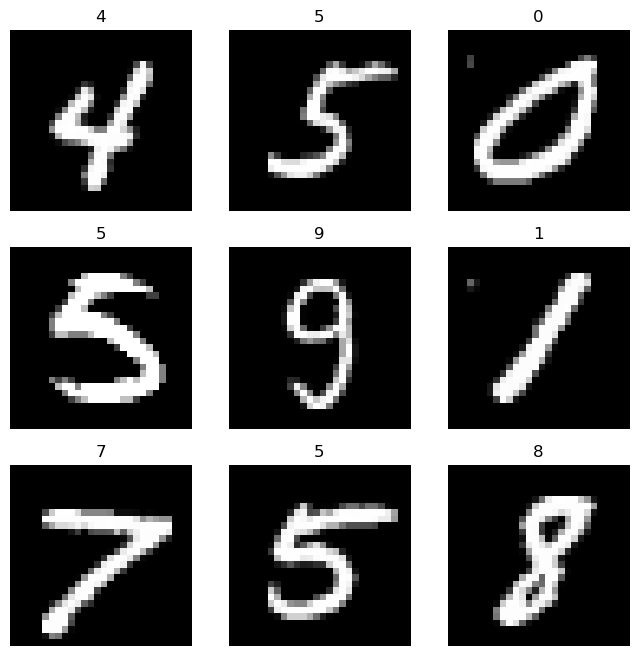

In [238]:
# plot the data
labels_map_minst = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map_minst[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
training_dataset[0][0].shape

torch.Size([1, 28, 28])

### scikit-learn implementation

In [ ]:
def get_mnist_data_sklearn(number_of_samples = 10000, split_percentage = 0.40):
    '''
    Return a subset of the MNIST dataset with the given number of samples
    :param number_of_samples: the number of samples to be returned
    :param split_percentage: the percentage of the data to be used for testing
    :return: X_train, X_test, y_train, y_test
    '''
    if (number_of_samples > 100000):
        raise Exception("Number of samples must be smaller than 100.000")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = X[:number_of_samples]
    y = y[:number_of_samples]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percentage, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = get_mnist_data_sklearn(10000, 0.40)
print("Number of training samples: ", len(X_train))
print("Number of test samples: ", len(X_test))
print("Number of train and test samples: ", len(X_train) + len(X_test))
print("Number of features: ", len(X_train[0]))
print("Number of classes: ", len(np.unique(y_train)))

Number of training samples:  6000
Number of test samples:  4000
Number of train and test samples:  10000
Number of features:  784
Number of classes:  10


In [ ]:
def plot_mnist_sklearn(X, y):
    '''
    Plot the first 9 images of the MNIST dataset
    param X: the data
    param y: the labels
    '''
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = np.random.randint(len(X))
        img = X[sample_idx]
        label = y[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.reshape(28,28), cmap="gray")
    plt.show()
        

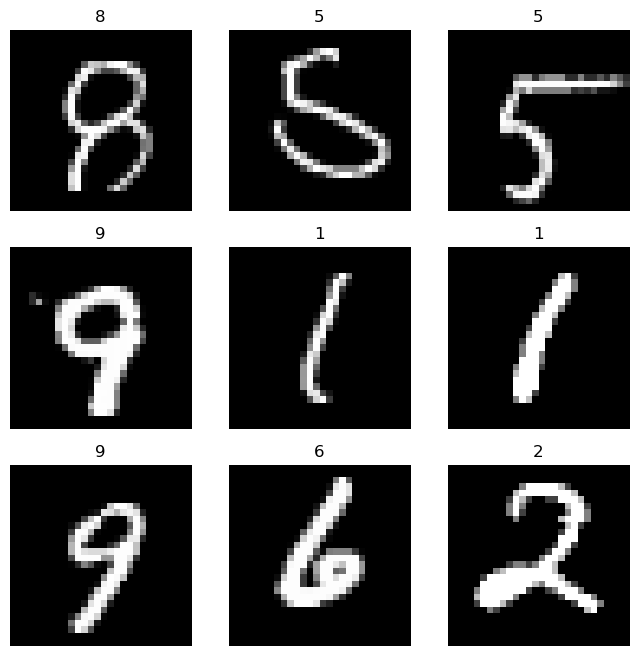

In [ ]:
plot_mnist_sklearn(X_train, y_train)

### Attempt 1: Fourier features
##### Made by: Hector Ramirez

In [ ]:
# I will start with Random Features as it is also an approximation of the kernel trick

### This is just the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#d = dim of the column vector x
#D is the number of features wanted in the output
def u_vectors(X_test, X_train ,D):
    """_summary_
    Args:
        X (matrix): Data matrix to transform dim (n,d)
        D int: Number of features wanted in the output

    Returns:
        u_test (matrix): matrix of the new features dim (n,D)
        u_train (matrix): matrix of the new features dim (n,D)
    """
    ## the d is the number of columns of X
    d= X_test.shape[1]
    F = np.random.normal(0,1/np.sqrt(d),(D, d))
    # I have to use the same F for the test and the train set to be consistent
    u_test = np.zeros((X_test.shape[0],D))
    u_train = np.zeros((X_train.shape[0],D))
    # Generating the new test set 
    for i in range(X_test.shape[0]):
        u_test[i,:] = (1/np.sqrt(D))*sigmoid(F@X_test[i])
    # Generating the training set 
    for j in range(X_train.shape[0]):
        u_train[j,:] = (1/np.sqrt(D))*sigmoid(F@X_train[j])
    
    return u_test, u_train

In [ ]:
def to_random_features(training_set, test_set, D):
    X_train = training_set.data.numpy().reshape(training_set.data.shape[0],-1)
    X_test = test_set.data.numpy().reshape(test_set.data.shape[0],-1)
    y_train = training_set.targets.numpy()
    y_test = test_set.targets.numpy()
    u_test, u_train = u_vectors(X_test, X_train, D)
    #Transform sets to numpy arrays
    #store the labels and the images in two different arrays
    #I can use the same training set for the test set as
    # validation set and let sk learn do the splitting
    
    return u_train, y_train, u_test, y_test

In [ ]:
# First I will make sure it works with a small number of features
D = 100
X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    D)

In [ ]:
def train_model(X_test, X_train, y_test, y_train):
    clf = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial')
    clf.fit(X_train, y_train)

    test_error = 1 - clf.score(X_test, y_test)
    train_error = 1 - clf.score(X_train, y_train)
    print("Accuracy on the test set: ", clf.score(X_test, y_test))
    print("Accuracy on the training set: ", clf.score(X_train, y_train))
    
    weights = clf.coef_
    norm = np.linalg.norm(weights, axis=1)
    number_of_features = X_train.shape[1]
    print("number of features: ", number_of_features)
    
    return norm, number_of_features, test_error, train_error

In [ ]:
Random_features = np.linspace(1000, 20000, 11, dtype=int)
#Random_features = np.append(Random_features, [30000, 40000, 50000, 60000])
train_loss = []
test_loss = []

Random_features

array([ 1000,  2900,  4800,  6700,  8600, 10500, 12400, 14300, 16200,
       18100, 20000])

In [ ]:
RF_df = pd.DataFrame(columns=['Number of features', 'Test error', 'Train error', 'Norm of the weights'])

for D in tqdm(Random_features, desc="Random Features"):
    X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    int(D))
    norm, number_of_features, test_error, train_error = train_model(X_test, X_train, y_test, y_train)
    RF_df = RF_df.append(
        {'Number of features': number_of_features,
         'Test error': test_error,
         'Train error': train_error,
         'Norm of the weights': norm},
        ignore_index=True)
    train_loss.append(train_error)
    test_loss.append(test_error)
    
RF_df.to_csv('Random_features.csv')

Random Features:   0%|          | 0/11 [00:00<?, ?it/s]/var/folders/xq/wkz5506d4vl23w8pv1zy5ysw0000gn/T/ipykernel_13831/187725555.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:   9%|▉         | 1/11 [00:32<05:24, 32.46s/it]

Accuracy on the test set:  0.9207
Accuracy on the training set:  0.9222166666666667
number of features:  1000


Text(0.5, 0, 'Number of features')

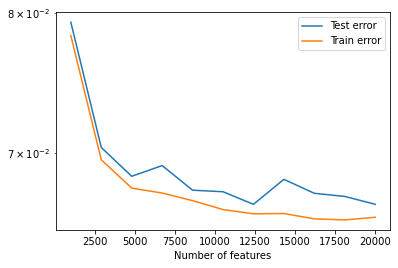

In [ ]:
plt.plot(RF_df['Number of features'], RF_df['Test error'], label="Test error")
plt.plot(RF_df['Number of features'], RF_df['Train error'], label="Train error")
#axs[2].plot(RF_df['Number of features'], RF_df['Norm of the weights'], label="Norm of the weights")
plt.legend()
plt.yscale("log")
plt.xlabel("Number of features")
plt.ylabel("Error")


In [ ]:
for D in tqdm([30000, 40000, 50000, 60000], desc="Random Features"):
    X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    int(D))
    norm, number_of_features, test_error, train_error = train_model(X_test, X_train, y_test, y_train)
    RF_df = RF_df.append(
        {'Number of features': number_of_features,
         'Test error': test_error,
         'Train error': train_error,
         'Norm of the weights': norm},
        ignore_index=True)
    train_loss.append(train_error)
    test_loss.append(test_error)

Random Features:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\hecma\AppData\Local\Temp\ipykernel_18576\1457717485.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Random Features:   0%|          | 0/4 [15:38<?, ?it/s]


KeyboardInterrupt: 

### Attempt 2: Neural Network

In [239]:
train_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

# Subset the training set to 4000 samples
train_subset = Subset(train_dataloader.dataset, np.arange(0, 4000))
test_subset = Subset(test_dataloader.dataset, np.arange(0, 1000))

# Create the dataloaders
train_loader = DataLoader(train_subset, batch_size = 128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size = 128, shuffle=True, num_workers=2)

In [240]:
print("Number of training samples: ", len(train_subset))
print("Number of test samples: ", len(test_subset))
print("Number of batches in the training set: ", len(train_loader))
print("Number of batches in the test set: ", len(test_loader))

Number of training samples:  4000
Number of test samples:  1000
Number of batches in the training set:  32
Number of batches in the test set:  8


In [241]:
class NeuralNetworkMSE(nn.Module):
    def __init__(self, current_count, param_counts, factor, hidden_layer_size):
        super(NeuralNetworkMSE, self).__init__()
        print(f'Neural Network with {hidden_layer_size} hidden units')
         
        d = 784
        K = 10
        self.input_layer = nn.Linear(28*28, hidden_layer_size)
        self.hidden_layer = nn.Linear(hidden_layer_size, 1)
    
    def forward(self, x):
        d = 784
        x = x.view(-1, d)
        x = F.relu(self.input_layer(x))
        x = self.hidden_layer(x)
        return x


In [242]:
class NeuralNetworkCross(nn.Module):
    def __init__(self, current_count, param_counts, factor, hidden_layer_size):
        super(NeuralNetworkCross, self).__init__()
        print(f'Neural Network with {hidden_layer_size} hidden units')
         
        d = 784
        K = 10
        self.input_layer = nn.Linear(28*28, hidden_layer_size)
        self.hidden_layer = nn.Linear(hidden_layer_size, 10)
    
    def forward(self, x):
        d = 784
        x = x.view(-1, d)
        x = F.relu(self.input_layer(x))
        x = self.hidden_layer(x)
        return x

In [197]:
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [243]:
from typing import Optional
from torch.nn import MSELoss


def train_epoch(model: nn.Module, train_dataloader: DataLoader, 
                optimizer: torch.optim.Optimizer, device: torch.device,
                loss_type: str):
    """
    Train the model for one epoch.
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then, we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    # train
    model = model.to(device)
    model.train()
    running_loss = 0.0
    #zero_one_running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_dataloader,0):

        # move data and target to device
        if loss_type == "MSE":
            data, target = data.to(device), target.to(torch.float32).to(device)
        else:
            data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        if loss_type == "MSE":
            lossmse = nn.MSELoss()
            loss = lossmse(output, target.view(-1,1))
        else:
            losscross = nn.CrossEntropyLoss()
            loss = losscross(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics 
        running_loss += loss.item()
        # running_loss += loss.item() * data.size(0) ???
        
    return running_loss / len(train_dataloader)


def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    loss_type: str):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # Train for numerous epochs:

    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        train_losses = train_epoch(model=model, train_dataloader=train_dataloader, optimizer=optimizer, device=device, loss_type=loss_type)
        train_loss.append(train_losses)
        
        test_losses = predict(model=model, test_dataloader=test_dataloader, optimizer=optimizer, device=device, loss_type=loss_type)
        test_loss.append(test_losses)

    return train_loss, test_loss


def predict(model: nn.Module, test_dataloader: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device, loss_type: str):
    model = model.to(device)
    model.eval()
    test_loss = 0
    zero_one_test_loss = 0
    for batch_idx, (data, target) in enumerate(test_dataloader):
        # move data and target to device
        if loss_type == "MSE":
            data, target = data.to(device), target.to(torch.float32).to(device)
        else:
            data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        if loss_type == "MSE":
            lossmse = nn.MSELoss()
            loss = lossmse(output, target.view(-1,1))
        else:
            losscross = nn.CrossEntropyLoss()
            loss = losscross(output, target)
     
        # print statistics
        test_loss += loss.item()
        # test_loss += loss.item() * data.size(0) ???
            
    return test_loss / len(test_dataloader)

In [244]:
def compute_hidden_layer_size(param_counts, current_count, factor, num_classes = 10):
    d = 784
    K = num_classes
    H = (param_counts[current_count] * factor - K)// (d + 1 + K)
    return H

In [246]:
#param_counts = np.array([3, 4, 7, 10, 15, 20, 23, 27, 31, 32, 33, 34, 36, 38, 40, 41, 42, 60, 100, 150, 300, 800])
param_counts = np.array([3, 4, 7, 10, 15, 20])
#param_counts = np.array([3, 4, 7, 10, 15, 20, 23, 27, 31, 32, 33, 34, 36, 38, 40, 41])
current_count = 0
schedular_step_size = 500
gamma = 0.9

factor = 10**3
K = 10
threshold = 4*factor*K
loss_dict = {'train': [], 'test': [], 'train_cross': [], 'test_cross': [], 'parameter_count': []}
while current_count < len(param_counts):
    reuse_weights = False
    hidden_layer_size = compute_hidden_layer_size(param_counts, current_count, factor)
    H = hidden_layer_size
    modelMSE = NeuralNetworkMSE(current_count, param_counts,factor, H)
    modelMSE = modelMSE.to(DEVICE)

    modelCross = NeuralNetworkCross(current_count, param_counts,factor, H)
    modelCross = modelCross.to(DEVICE)

    # use weight reuse scheme in the under-parameterized regime
    #if (param_counts[current_count]*factor) < threshold:
    #    reuse_weights = True
    #if reuse_weights:
    #    in_weights = torch.randn_like(model.input_layer.weight)*.01
    #    hidden_weights = torch.randn_like(model.hidden_layer.weight)*.01

    #    in_weights[:model.input_layer.weight.shape[0]] = model.input_layer.weight
    #    hidden_weights[:,:model.hidden_layer.weight.shape[1]] = model.hidden_layer.weight[:]

     #   model.input_layer.weights = nn.Parameter(in_weights)
     #   model.hidden_layer.weights = nn.Parameter(hidden_weights)
    
    optimizerMSE = optim.SGD(modelMSE.parameters(), lr=0.01, momentum=0.95)
    optimizerCross = optim.SGD(modelCross.parameters(), lr=0.01, momentum=0.95)
    #if param_counts[current_count] * factor > 4000 * 10:
    #    gamma = 1
    #scheduler = optim.lr_scheduler.StepLR(optimizerMSE, step_size=schedular_step_size, gamma=gamma)
    
    train_loss, test_loss = fit(model = modelMSE, train_dataloader = train_loader, 
                                test_dataloader = test_loader, optimizer = optimizerMSE, epochs=5, device=DEVICE, loss_type = "MSE")
    train_loss_cross, test_loss_cross = fit(model = modelCross, train_dataloader = train_loader, 
                                            test_dataloader = test_loader, optimizer = optimizerCross, epochs=5, device=DEVICE, loss_type = "Cross")

    loss_dict['train'] = np.append(loss_dict['train'], train_loss[-1])
    loss_dict['test'] = np.append(loss_dict['test'], test_loss[-1])
    loss_dict['train_cross'] = np.append(loss_dict['train_cross'], train_loss_cross[-1])
    loss_dict['test_cross'] = np.append(loss_dict['test_cross'], test_loss_cross[-1])
    loss_dict['parameter_count'] = np.append(loss_dict['parameter_count'], param_counts[current_count])
    current_count += 1

Neural Network with 3 hidden units
Neural Network with 3 hidden units
Neural Network with 5 hidden units
Neural Network with 5 hidden units
Neural Network with 8 hidden units
Neural Network with 8 hidden units
Neural Network with 12 hidden units
Neural Network with 12 hidden units
Neural Network with 18 hidden units
Neural Network with 18 hidden units
Neural Network with 25 hidden units
Neural Network with 25 hidden units


In [247]:
loss_dict

{'train': array([8.20869607, 4.12061762, 2.81257299, 2.46601165, 8.04193266,
        4.50112862]),
 'test': array([8.03354651, 4.19809017, 3.32145056, 2.90846956, 6.54691172,
        3.91120753]),
 'train_cross': array([1.11288827, 0.59487621, 0.48615844, 0.43443781, 0.37492383,
        0.36287436]),
 'test_cross': array([1.18337871, 0.67745339, 0.55478663, 0.49195308, 0.47521944,
        0.48878808]),
 'parameter_count': array([ 3.,  4.,  7., 10., 15., 20.])}

In [248]:
def plot_NN(result_dict):
    '''
    Plot the double descent curve for the Random Forest Classifier
    :param result_dict: the returned dictionary from the double_descent_RF function
    '''
    fig, ax = plt.subplots(figsize=(8, 6), sharey = True)

    #define xticks
    #tick_location = [0, 10, 20, 30, 40]
    #tick_label = ['10 / 1', '1000 / 1', '2000 / 1', '2000 / 10', '2000 / 20']

    plt.subplot(2,1,1)
    plt.title(f'Neural network model: Double descent curve')
    plt.plot(range(len(result_dict['train'])), result_dict['train'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['test'])), result_dict['test'], 
             color='tab:blue', label = 'Test')
    #plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Squared loss')
    #plt.xticks(tick_location, [])
    #plt.ylim(-0.001, 0.07)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(range(len(result_dict['train_cross'])), result_dict['train_cross'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['test_cross'])), result_dict['test_cross'], 
             color='tab:blue', label = 'Test')
    #plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Cross-entropy loss')
    plt.xlabel('Model parameters')
    #plt.ylim(-0.5, 35)
    #plt.xticks(tick_location, tick_label)

    #plt.show()

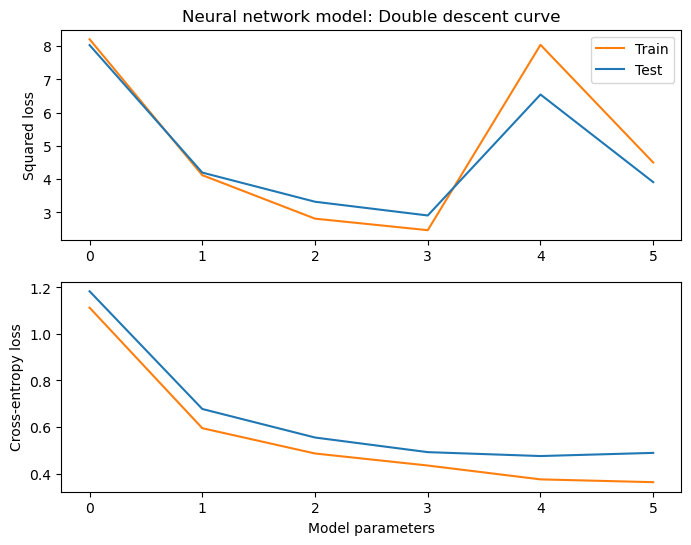

In [249]:
plot_NN(loss_dict)

### Attempt 3: Random Forests

In [ ]:
def sk_zero_one_loss(y_true, y_pred):
    '''
    Returns the percentage of misclassifications
    :param y_true: ground truth (correct) labels
    :param y_pred: predicted labels, as returned by a classifier
    :return: the zero-one classification loss
    '''
    return zero_one_loss(y_true, y_pred)*100

def sk_mean_squared_error(y_true, y_pred):
    '''
    Returns the mean squared error regression loss
    :param y_true: ground truth (correct) labels
    :param y_pred: predicted labels, as returned by a classifier
    :return: the mean squared error regression loss
    '''
    return mean_squared_error(y_true, y_pred)
    
def one_hot_encode(data, classes=10):
    '''
    Represent categorical variables as binary vectors (one-hot encoding).
    :param data: an array that we perform the One Hot Encoding on, i.e., we transform each datapoint to a binary vector
    :param classes: number of classes we aim to identify in the dataset
    :return: a numpy array with the one-hot encoded data
    '''
    onehot_encoded = []
    for value in data:
        vec = np.array([0] * classes)
        vec[int(value)] = 1
        onehot_encoded.append(vec)
        
    return np.stack(onehot_encoded)

In [ ]:

def double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100, 
                      X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    '''
    Train a Random Forest Classifier over several different values of the parameters number of trees (N_tree)
    and the maximum number of leaves allowed for each tree (N_max_leaf)
    :param tree_bound: the upper bound for N_tree
    :param leaves_bound: the upper bound for N_max_leaf
    :param tree_step: the step for N_tree
    :param leaves_step: the step for N_max_leaf
    :param X_train: the train data 
    :param y_train: the train targets
    :param X_test: the test data
    :param y_test: the test targets
    :param rep: the number of repetitions of experiments
    :return: result_dict
    '''

    # we initialize the model with N_tree = 1 and N_max_leaf = 10
    N_max_leaves = 10
    N_tree = 1
    model = RandomForestClassifier(n_estimators=N_tree, 
                                   bootstrap=False, 
                                   criterion='gini', 
                                   max_leaf_nodes=N_max_leaves,
                                   max_features='sqrt',
                                   max_depth = None)
    
    leaf_sizes = []
    trees = []

    # initialize training losses
    zero_one_train_losses = []
    mse_train_losses = []
    
    # initialize testing losses
    zero_one_test_losses = []
    mse_test_losses = []

    while N_max_leaves <= leaves_bound:

        model.fit(X_train, y_train)
        
        # find training loss
        zero_one_train_loss = sk_zero_one_loss(y_train, model.predict(X_train))
        mse_train_loss = sk_mean_squared_error(one_hot_encode(y_train), one_hot_encode(model.predict(X_train)))
        
        # find testing loss
        zero_one_test_loss = sk_zero_one_loss(y_test, model.predict(X_test))   
        mse_test_loss = sk_mean_squared_error(one_hot_encode(y_test), one_hot_encode(model.predict(X_test)))
        
        # add training and testing loss to the training and testing losses arrays
        zero_one_train_losses = np.append(zero_one_train_losses, zero_one_train_loss)
        mse_train_losses = np.append(mse_train_losses, mse_train_loss)
        
        zero_one_test_losses = np.append(zero_one_test_losses, zero_one_test_loss)
        mse_test_losses = np.append(mse_test_losses, mse_test_loss)

        leaf_sizes.append(N_max_leaves)
        trees.append(N_tree)
        
        if (N_max_leaves == 10):
            N_max_leaves = leaves_step
        else:
            N_max_leaves += leaves_step
                
        # define the model for every new value of N_max_leaves  
        model = RandomForestClassifier(n_estimators=N_tree, 
                                       bootstrap=False, 
                                       criterion='gini', 
                                       max_leaf_nodes=N_max_leaves,
                                       max_features='sqrt',
                                       max_depth = None)

    N_max_leaves = N_max_leaves - leaves_step
                
    while N_tree <= tree_bound:
            
        # define the model for every new value of N_tree
        model = RandomForestClassifier(n_estimators=N_tree, 
                                       bootstrap=False, 
                                       criterion='gini', 
                                       max_leaf_nodes=N_max_leaves,
                                       max_features='sqrt',
                                       max_depth = None)
        
        model.fit(X_train, y_train)

        # find training loss
        zero_one_train_loss = sk_zero_one_loss(y_train, model.predict(X_train))
        mse_train_loss = sk_mean_squared_error(one_hot_encode(y_train), one_hot_encode(model.predict(X_train)))
        
        # find testing loss
        zero_one_test_loss = sk_zero_one_loss(y_test, model.predict(X_test))   
        mse_test_loss = sk_mean_squared_error(one_hot_encode(y_test), one_hot_encode(model.predict(X_test)))

        # add training and testing loss to the training and testing losses arrays
        zero_one_train_losses = np.append(zero_one_train_losses, zero_one_train_loss)
        mse_train_losses = np.append(mse_train_losses, mse_train_loss)
        
        zero_one_test_losses = np.append(zero_one_test_losses, zero_one_test_loss)
        mse_test_losses = np.append(mse_test_losses, mse_test_loss)

        leaf_sizes.append(N_max_leaves)
        trees.append(N_tree)
            
        N_tree += tree_step
            
    result_dict = {'zero_one_train_loss': zero_one_train_losses, 
                   'mse_train_loss': mse_train_losses, 
                   'zero_one_test_loss': zero_one_test_losses,
                   'mse_test_loss': mse_test_losses,
                   'leaf_sizes': np.array(leaf_sizes), 
                   'trees': np.array(trees)}    
    
    return result_dict

In [ ]:
out = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100, 
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
out = {'zero_one_train_loss': np.array(0), 
        'mse_train_loss': np.array(0), 
        'zero_one_test_loss': np.array(0),
        'mse_test_loss': np.array(0),
        'leaf_sizes': np.array(0), 
        'trees': np.array(0)} 

In [ ]:
# call double_descent five times and return the average of the results
out1 = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100,
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)
out2 = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100,
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)    
out3 = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100,
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)
out4 = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100,    
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)
out5 = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100,
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                        

In [ ]:
# average the results
out['zero_one_train_loss'] = (out1['zero_one_train_loss'] + out2['zero_one_train_loss'] + out3['zero_one_train_loss'] + out4['zero_one_train_loss'] + out5['zero_one_train_loss'])/5
out['mse_train_loss'] = (out1['mse_train_loss'] + out2['mse_train_loss'] + out3['mse_train_loss'] + out4['mse_train_loss'] + out5['mse_train_loss'])/5
out['zero_one_test_loss'] = (out1['zero_one_test_loss'] + out2['zero_one_test_loss'] + out3['zero_one_test_loss'] + out4['zero_one_test_loss'] + out5['zero_one_test_loss'])/5
out['mse_test_loss'] = (out1['mse_test_loss'] + out2['mse_test_loss'] + out3['mse_test_loss'] + out4['mse_test_loss'] + out5['mse_test_loss'])/5
out['leaf_sizes'] = (out1['leaf_sizes'] + out2['leaf_sizes'] + out3['leaf_sizes'] + out4['leaf_sizes'] + out5['leaf_sizes'])/5
out['trees'] = (out1['trees'] + out2['trees'] + out3['trees'] + out4['trees'] + out5['trees'])/5

In [ ]:
def plot_RF(result_dict):
    '''
    Plot the double descent curve for the Random Forest Classifier
    :param result_dict: the returned dictionary from the double_descent_RF function
    '''
    fig, ax = plt.subplots(figsize=(8, 6), sharey = True)

    #define xticks
    tick_location = [0, 10, 20, 30, 40]
    tick_label = ['10 / 1', '1000 / 1', '2000 / 1', '2000 / 10', '2000 / 20']

    plt.subplot(2,1,1)
    plt.title(f'Random Forest model: Double descent curve')
    plt.plot(range(len(result_dict['mse_train_loss'])), result_dict['mse_train_loss'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['mse_test_loss'])), result_dict['mse_test_loss'], 
             color='tab:blue', label = 'Test')
    plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Squared loss')
    plt.xticks(tick_location, [])
    plt.ylim(-0.001, 0.07)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(range(len(result_dict['zero_one_train_loss'])), result_dict['zero_one_train_loss'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['zero_one_test_loss'])), result_dict['zero_one_test_loss'], 
             color='tab:blue', label = 'Test')
    plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Zero-one loss (%)')
    plt.xlabel('Model parameters: $N_{leaf}^{max}$ / $N_{tree}$')
    plt.ylim(-0.5, 35)
    plt.xticks(tick_location, tick_label)

    #plt.show()

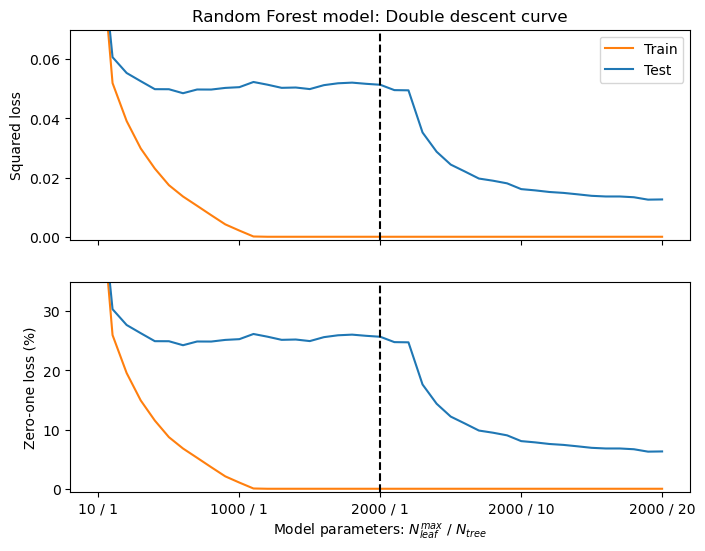

In [ ]:
fig = plot_RF(out)
# save figure
plt.savefig('RF_double_descent.png', dpi=300)
